# Programming Exercise 7:
# K-means Clustering 
## Introduction

In this exercise, you will implement the K-means clustering algorithm and apply it to compress an image. 
Before we begin with the exercises, we need to import all libraries required for this programming exercise. We will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, [`matplotlib`](https://matplotlib.org/) for plotting, and [`scipy`](https://docs.scipy.org/doc/scipy/reference/) for scientific and numerical computation functions and tools.

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Import regular expressions to process emails
import re

# Plotting library
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

from IPython.display import HTML, display, clear_output

try:
    pyplot.rcParams["animation.html"] = "jshtml"
except ValueError:
    pyplot.rcParams["animation.html"] = "html5"

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions and others
import utils

%load_ext autoreload
%autoreload 2



# tells matplotlib to embed plots within the notebook
%matplotlib inline

## 1 K-means Clustering

In this exercise, you will implement K-means algorithm and use it for image compression. You will first start on an example 2D dataset that will help you gain an intuition of how the K-means algorithm works. After
that, you wil use the K-means algorithm for image compression by reducing the number of colors that occur in an image to only those that are most common in that image.

### 1.1 Implementing K-means

The K-means algorithm is a method to automatically cluster similar data examples together. Concretely, you are given a training set $\{x^{(1)} , \cdots, x^{(m)}\}$ (where $x^{(i)} \in \mathbb{R}^n$), and want to group the data into a few cohesive “clusters”. The intuition behind K-means is an iterative procedure that starts by guessing the initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments.

The K-means algorithm is as follows:

```python
centroids = kMeansInitCentroids(X, K)
for i in range(iterations):
    # Cluster assignment step: Assign each data point to the
    # closest centroid. idx[i] corresponds to cˆ(i), the index
    # of the centroid assigned to example i
    idx = findClosestCentroids(X, centroids)
    
    # Move centroid step: Compute means based on centroid
    # assignments
    centroids = computeMeans(X, idx, K)
```

The inner-loop of the algorithm repeatedly carries out two steps: (1) Assigning each training example $x^{(i)}$ to its closest centroid, and (2) Recomputing the mean of each centroid using the points assigned to it. The K-means algorithm will always converge to some final set of means for the centroids. Note that the converged solution may not always be ideal and depends on the initial setting of the centroids. Therefore, in practice the K-means algorithm is usually run a few times with different random initializations. One way to choose between these different solutions from different random initializations is to choose the one with the lowest cost function value (distortion). You will implement the two phases of the K-means algorithm separately
in the next sections.

<a id="section1"></a>
#### 1.1.1 Finding closest centroids

In the “cluster assignment” phase of the K-means algorithm, the algorithm assigns every training example $x^{(i)}$ to its closest centroid, given the current positions of centroids. Specifically, for every example $i$ we set

$$c^{(i)} := j \quad \text{that minimizes} \quad \lvert\rvert x^{(i)} - \mu_j  \lvert\rvert^2, $$

where $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$, and $\mu_j$ is the position (value) of the $j^{th}$ centroid. Note that $c^{(i)}$ corresponds to `idx[i]` in the starter code.

Your task is to complete the code in the function `findClosestCentroids`. This function takes the data matrix `X` and the locations of all centroids inside `centroids` and should output a one-dimensional array `idx` that holds the index (a value in $\{1, ..., K\}$, where $K$ is total number of centroids) of the closest centroid to every training example.

You can implement this using a loop over every training example and every centroid.
<a id="findClosestCentroids"></a>

In [5]:
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
def findClosestCentroids(X, centroids):
    """
    Computes the centroid memberships for every example.
    
    Parameters
    ----------
    X : array_like
        The dataset of size (m, n) where each row is a single example. 
        That is, we have m examples each of n dimensions.
        
    centroids : array_like
        The k-means centroids of size (K, n). K is the number
        of clusters, and n is the the data dimension.
    
    Returns
    -------
    idx : array_like
        A vector of size (m, ) which holds the centroids assignment for each
        example (row) in the dataset X.
    
    Instructions
    ------------
    Go over every example, find its closest centroid, and store
    the index inside `idx` at the appropriate location.
    Concretely, idx[i] should contain the index of the centroid
    closest to example i. Hence, it should be a value in the 
    range 0..K-1

    Note
    ----
    You can use a for-loop over the examples to compute this.
    """
    # Set K
    K = centroids.shape[0]

    # You need to return the following variables correctly.
    idx = np.zeros(X.shape[0], dtype=int)

    # ====================== YOUR CODE HERE ======================

    idx = pairwise_distances_argmin_min(X,centroids)[0]

    
    # =============================================================
    return idx

Once you have completed the code in `findClosestCentroids`, the following cell will run your code and you should see the output `[0 2 1]` corresponding to the centroid assignments for the first 3 examples.

In [6]:
# Load an example dataset that we will be using
data = loadmat(os.path.join('Data', 'ex7data2.mat'))
X = data['X']

# Select an initial set of centroids
K = 3   # 3 Centroids
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

# Find the closest centroids for the examples using the initial_centroids
idx = findClosestCentroids(X, initial_centroids)

print('Closest centroids for the first 3 examples:')
print(idx[:3])
print('(the closest centroids should be 0, 2, 1 respectively)')

Closest centroids for the first 3 examples:
[0 2 1]
(the closest centroids should be 0, 2, 1 respectively)


<a id="section2"></a>
### 1.1.2 Computing centroid means

Given assignments of every point to a centroid, the second phase of the algorithm recomputes, for each centroid, the mean of the points that were assigned to it. Specifically, for every centroid $k$ we set

$$ \mu_k := \frac{1}{\left| C_k\right|} \sum_{i \in C_k} x^{(i)}$$

where $C_k$ is the set of examples that are assigned to centroid $k$. Concretely, if two examples say $x^{(3)}$ and $x^{(5)}$ are assigned to centroid $k = 2$, then you should update $\mu_2 = \frac{1}{2} \left( x^{(3)} + x^{(5)} \right)$.

You should now complete the code in the function `computeCentroids`. You can implement this function using a loop over the centroids. You can also use a loop over the examples; but if you can use a vectorized implementation that does not use such a loop, your code may run faster.
<a id="computeCentroids"></a>

In [7]:
def computeCentroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the data points
    assigned to each centroid.
    
    Parameters
    ----------
    X : array_like
        The datset where each row is a single data point. That is, it 
        is a matrix of size (m, n) where there are m datapoints each
        having n dimensions. 
    
    idx : array_like 
        A vector (size m) of centroid assignments (i.e. each entry in range [0 ... K-1])
        for each example.
    
    K : int
        Number of clusters
    
    Returns
    -------
    centroids : array_like
        A matrix of size (K, n) where each row is the mean of the data 
        points assigned to it.
    
    Instructions
    ------------
    Go over every centroid and compute mean of all points that
    belong to it. Concretely, the row vector centroids[i, :]
    should contain the mean of the data points assigned to
    cluster i.

    Note:
    -----
    You can use a for-loop over the centroids to compute this.
    """
    # Useful variables
    m, n = X.shape
    # You need to return the following variables correctly.
    centroids = np.zeros((K, n))


    # ====================== YOUR CODE HERE ======================
    for i in range(K):
      index = np.array(np.where(idx==i)).ravel()
      length = len(index)
      centroids[i] = np.mean(X[index,:],axis=0)
    
    
    # =============================================================
    return centroids

Once you have completed the code in `computeCentroids`, the following cell will run your code and output the centroids after the first step of K-means.

In [8]:
# Compute means based on the closest centroids found in the previous part.
centroids = computeCentroids(X, idx, K)

print('Centroids computed after initial finding of closest centroids:')
print(centroids)
print('\nThe centroids should be')
print('   [ 2.428301 3.157924 ]')
print('   [ 5.813503 2.633656 ]')
print('   [ 7.119387 3.616684 ]')

Centroids computed after initial finding of closest centroids:
[[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]

The centroids should be
   [ 2.428301 3.157924 ]
   [ 5.813503 2.633656 ]
   [ 7.119387 3.616684 ]


### 1.2 K-means on example dataset 

After you have completed the two functions (`findClosestCentroids` and `computeCentroids`), you have all the necessary pieces to run the K-means algorithm. The next cell  will run the K-means algorithm on a toy 2D dataset to help you understand how K-means works. Your functions are called from inside the `runKmeans` function (in this assignment's `utils.py` module). We encourage you to take a look at the function to understand how it works. Notice that the code calls the two functions you implemented in a loop.

When you run the next step, the K-means code will produce an animation that steps you through the progress of the algorithm at each iteration. At the end, your figure should look as the one displayed below.

![](Figures/kmeans_result.png)

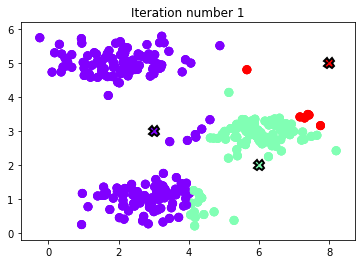

In [9]:
# Load an example dataset
data = loadmat(os.path.join('Data', 'ex7data2.mat'))

# Settings for running K-Means
K = 3
max_iters = 10

# For consistency, here we set centroids to specific values
# but in practice you want to generate them automatically, such as by
# settings them to be random examples (as can be seen in
# kMeansInitCentroids).
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])


# Run K-Means algorithm. The 'true' at the end tells our function to plot
# the progress of K-Means
centroids, idx, anim = utils.runkMeans(X, initial_centroids,
                                       findClosestCentroids, computeCentroids, max_iters, True)
anim

### 1.3 Random initialization 

The initial assignments of centroids for the example dataset in the previous cell were designed so that you will see the same figure as that shown in the cell above. In practice, a
good strategy for initializing the centroids is to select random examples from the training set.

In this part of the exercise, you should complete the function `kMeansInitCentroids` with the following code:

```python
# Initialize the centroids to be random examples

# Randomly reorder the indices of examples
randidx = np.random.permutation(X.shape[0])
# Take the first K examples as centroids
centroids = X[randidx[:K], :]
```

The code above first randomly permutes the indices of the examples (using `permute` within the `numpy.random` module). Then, it selects the first $K$ examples based on the random permutation of the indices. This allows the examples to be selected at random without the risk of selecting the same example twice.

<a id="kMeansInitCentroids"></a>

In [11]:
def kMeansInitCentroids(X, K):
    """
    This function initializes K centroids that are to be used in K-means on the dataset x.
    
    Parameters
    ----------
    X : array_like 
        The dataset of size (m x n).
    
    K : int
        The number of clusters.
    
    Returns
    -------
    centroids : array_like
        Centroids of the clusters. This is a matrix of size (K x n).
    
    Instructions
    ------------
    You should set centroids to randomly chosen examples from the dataset X.
    """
    m, n = X.shape
    
    # You should return this values correctly
    centroids = np.zeros((K, n))

    # ====================== YOUR CODE HERE ======================
    randindex = np.random.permutation(m)
    centroids = X[randindex[:K],:]

    
    # =============================================================
    return centroids

### 1.4 Image compression with K-means

In this exercise, you will apply K-means to image compression. We will use the image below as an example (property of Frank Wouters with permission to this class).

![](Data/bird_small.png)

In a straightforward 24-bit color representation of an image, each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often referred to as the RGB encoding. Our image contains thousands of colors, and in this part of the exercise, you will reduce the number of colors to 16 colors.

By making this reduction, it is possible to represent (compress) the photo in an efficient way. Specifically, you only need to store the RGB values of the 16 selected colors, and for each pixel in the image you now need to only store the index of the color at that location (where only 4 bits are necessary to represent 16 possibilities).

In this exercise, you will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image. Concretely, you will treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3-dimensional RGB space. Once you have computed the cluster centroids on the image, you will then use the 16 colors to replace the pixels in the original image.

#### 1.4.1 K-means on pixels

In python, images can be read in as follows:

```python
# Load 128x128 color image (bird_small.png)
img = mpl.image.imread(os.path.join('Data', 'bird_small.png'))

# We have already imported matplotlib as mpl at the beginning of this notebook.
```
This creates a three-dimensional matrix `A` whose first two indices identify a pixel position and whose last index represents red, green, or blue. For example, A[50, 33, 2] gives the blue intensity of the pixel at row 51 and column 34.

The code in the following cell first loads the image, and then reshapes it to create an m x 3 matrix of pixel colors (where m = 16384 = 128 x 128), and calls your K-means function on it.

After finding the top K = 16 colors to represent the image, you can now assign each pixel position to its closest centroid using the `findClosestCentroids` function. This allows you to represent the original image using the centroid assignments of each pixel. Notice that you have significantly reduced the number of bits that are required to describe the image. The original image required 24 bits for each one of the 128 x 128 pixel locations, resulting in total size of 128 x 128 x 24 = 393,216 bits. The new representation requires some overhead storage in form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location. The final number of bits used is therefore 16 x 24 + 128 x 128 x 4 = 65,920 bits, which corresponds to compressing the original image by about a factor of 6.

Finally, you can view the effects of the compression by reconstructing the image based only on the centroid assignments. Specifically, you can replace each pixel location with the mean of the centroid assigned to it. The figure below shows the reconstruction we obtained. 

![](Figures/bird_compression.png)

Even though the resulting image retains most of the characteristics of the original, we also see some compression artifacts.

Run the following cell to compute the centroids and the centroid allocation of each pixel in the image.

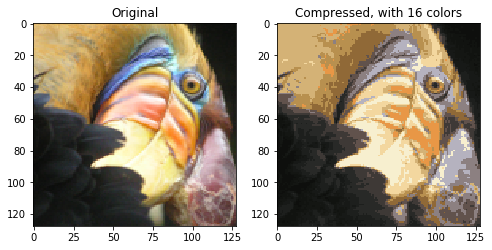

In [15]:
# ======= Experiment with these parameters ================
# You should try different values for those parameters
K = 16
max_iters = 10

# Load an image of a bird
# Change the file name and path to experiment with your own images
A = mpl.image.imread(os.path.join('Data', 'bird_small.png'))
# ==========================================================

# Divide by 255 so that all values are in the range 0 - 1
A /= 255

# Reshape the image into an Nx3 matrix where N = number of pixels.
# Each row will contain the Red, Green and Blue pixel values
# This gives us our dataset matrix X that we will use K-Means on.
X = A.reshape(-1, 3)

# When using K-Means, it is important to randomly initialize centroids
# You should complete the code in kMeansInitCentroids above before proceeding
initial_centroids = kMeansInitCentroids(X, K)

# Run K-Means
centroids, idx = utils.runkMeans(X, initial_centroids,
                                 findClosestCentroids,
                                 computeCentroids,
                                 max_iters)

# We can now recover the image from the indices (idx) by mapping each pixel
# (specified by its index in idx) to the centroid value
# Reshape the recovered image into proper dimensions
X_recovered = centroids[idx, :].reshape(A.shape)

# Display the original image, rescale back by 255
fig, ax = pyplot.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(A*255)
ax[0].set_title('Original')
ax[0].grid(False)

# Display compressed image, rescale back by 255
ax[1].imshow(X_recovered*255)
ax[1].set_title('Compressed, with %d colors' % K)
ax[1].grid(False)

### 1.5 Use your own image

In this exercise, modify the code we have supplied in the previous cell to run on one of your own images. Note that if your image is very large, then K-means can take a long time to run. Therefore, we recommend that you resize your images to
manageable sizes before running the code. You can also try to vary $K$ to see the effects on the compression.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


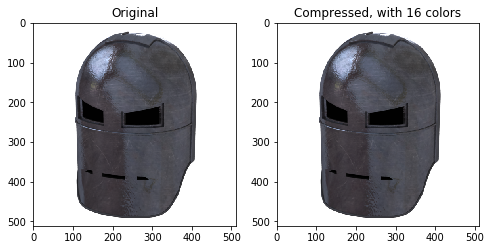

In [26]:
# ======= Experiment with these parameters ================
# You should try different values for those parameters
K = 16
max_iters = 10

# Load an image of a bird
# Change the file name and path to experiment with your own images
A = mpl.image.imread(os.path.join('Data', 'mask.png'))
# ==========================================================

# Divide by 255 so that all values are in the range 0 - 1
A /= 255

# Reshape the image into an Nx3 matrix where N = number of pixels.
# Each row will contain the Red, Green and Blue pixel values
# This gives us our dataset matrix X that we will use K-Means on.
X = A.reshape(-1, 262144 )

# When using K-Means, it is important to randomly initialize centroids
# You should complete the code in kMeansInitCentroids above before proceeding
initial_centroids = kMeansInitCentroids(X, K)

# Run K-Means
centroids, idx = utils.runkMeans(X, initial_centroids,
                                 findClosestCentroids,
                                 computeCentroids,
                                 max_iters)

# We can now recover the image from the indices (idx) by mapping each pixel
# (specified by its index in idx) to the centroid value
# Reshape the recovered image into proper dimensions
X_recovered = centroids[idx, :].reshape(A.shape)

# Display the original image, rescale back by 255
fig, ax = pyplot.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(A*255)
ax[0].set_title('Original')
ax[0].grid(False)

# Display compressed image, rescale back by 255
ax[1].imshow(X_recovered*255)
ax[1].set_title('Compressed, with %d colors' % K)
ax[1].grid(False)